In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

from desc.compute import compute_geometry, data_index
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import LinearGrid
from desc.objectives import MagneticWell
from desc.plotting import plot_surfaces
from desc.transform import Transform

DESC version 0.4.13+574.g054f692.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 11.04 GB available memory


In [11]:
class MagneticWellVisual:
    """
    To print and plot more (less) quantities, add (remove) them to the dict
    returned from MagneticWell.compute() and self.st and data_variables.
    Everything else is automatic.
    """

    X = 0  # index of coordinate tuple (x_pts, y_pts)
    Y = 1  # index of coordinate tuple (x_pts, y_pts)
    data_variables = ()  # tuple of keys returned in data dict

    def __init__(
        self,
        name,
        eq=None,
        has_stellopt_data=False,
        use_stellopt_rho=False,
        rho=np.linspace(1 / 32, 1, 32),  # number of points to plot, reduce for speed
    ):
        """
        Make a MagneticWellVisual from either the provided equilibrium
        or the final equilibrium loaded from the output.h5 solution.
        If the latter option is chosen, name should match prefix of
        of the examples/DESC/<name>_output.h5 file
        """
        self.name = name
        if eq is None:
            # collect final equilibrium
            eq = EquilibriaFamily.load(
                load_from="examples/DESC/" + name + "_output.h5"
            )[-1]
        self.eq = eq
        self.st = dict()  # values are tuples of (x[i], y[i]) of plotable data

        if has_stellopt_data:
            # pull stellopt data from matlab .mat file
            mat = sio.loadmat("magwell-data/" + name + "_magwell.mat")
            self.st["STELLOPT Magnetic Well"] = mat["rho"], mat["magwell"]
            if use_stellopt_rho:
                rho = mat["rho"]

        # y points are cached when compute_plot() is called
        self.rho = rho
        l = len(rho)
        self.st["DESC Magnetic Well v1"] = rho, np.empty(l)
        self.st["DESC Magnetic Well v2"] = rho, np.empty(l)
        self.st["volume"] = rho, np.empty(l)
        self.st["dvolume/drho"] = rho, np.empty(l)
        self.st["d(thermal pressure)/drho"] = rho, np.empty(l)
        self.st["d(thermal pressure)/dvolume"] = rho, np.empty(l)
        self.st["d(magnetic pressure)/dvolume average v1"] = rho, np.empty(l)
        self.st["d(magnetic pressure average)/dvolume v2"] = rho, np.empty(l)
        self.st["d(total pressure average)/dvolume"] = rho, np.empty(l)
        self.st["Bsquare average"] = rho, np.empty(l)

    def print_values(self, grid=None, print_data_V=True, print_stellopt=False):
        """
        Prints what is returned by MagneticWell.compute().
        The default grid=None uses the rho=1 flux surface.
        """
        print(self.name)
        print(self.eq)
        mw = MagneticWell(eq=self.eq, grid=grid)
        # helpful to see the grid
        # although this grid is from a rho=1 MagneticWell, grid.spacing
        # is the same for any rho=constant surfaces of a given equilibrium
        print("grid.spacing(dr,dt,dz)", mw.grid.spacing[0])
        m = mw.compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.Psi,
        )
        for key, val in m.items():
            if key == "data":
                for var in MagneticWellVisual.data_variables:
                    print('{0}["{1}"] {2}'.format(key, var, val[var]))
            else:
                print(key, val)
        if print_data_V:
            self.print_data_V()
        if print_stellopt:
            self.print_stellopt()
        print()

    def print_data_V(self):
        """
        Print the volume of the stellerator device as computed by data["V"].
        Should match V surface integral when the default grid with rho = 1
        is used to construct the MagneticWell() object.
        """
        # need grid with array for rho to compute accurate data["V"]
        # different than grid used in MagneticWell() construction
        grid = LinearGrid(
            M=2 * self.eq.M_grid + 1,
            N=2 * self.eq.N_grid + 1,
            NFP=self.eq.NFP,
            sym=self.eq.sym,
            rho=np.linspace(1 / 128, 1, 128),
        )
        R_transform = Transform(
            grid, self.eq.R_basis, derivs=data_index["sqrt(g)"]["R_derivs"], build=True
        )
        Z_transform = Transform(
            grid, self.eq.Z_basis, derivs=data_index["sqrt(g)"]["R_derivs"], build=True
        )
        data = compute_geometry(self.eq.R_lmn, self.eq.Z_lmn, R_transform, Z_transform)
        print('data["V"]', data["V"])

    def print_stellopt(self):
        """Print the STELLOPT magnetic well data."""
        if (s := "STELLOPT Magnetic Well") in self.st:
            print(s)
            rho, well = self.st[s]
            for i in range(len(rho)):
                print(rho[i], well[i])

    def compute_plot(self):
        """
        Compute and cache MagneticWell.compute() values for the given
        array of rho=constant surfaces.
        """
        for i in range(len(self.rho)):
            mw = MagneticWell(
                eq=self.eq,
                grid=LinearGrid(
                    L=1,
                    M=2 * self.eq.M_grid + 10,  # +1 not enough for volume
                    N=2 * self.eq.N_grid + 10,
                    NFP=self.eq.NFP,
                    sym=False,  # required for correctness of volume
                    rho=self.rho[i],
                ),
            )
            m = mw.compute(
                self.eq.R_lmn,
                self.eq.Z_lmn,
                self.eq.L_lmn,
                self.eq.p_l,
                self.eq.i_l,
                self.eq.Psi,
            )

            # cache computed quantity in the y coordinate array
            for key, val in m.items():
                if key == "data":
                    for var in MagneticWellVisual.data_variables:
                        # for arrays like "p_r" just get first element
                        y = val[var][0] if val[var].ndim > 0 else val[var]
                        self.st[var][MagneticWellVisual.Y][i] = y
                elif key in self.st:
                    self.st[key][MagneticWellVisual.Y][i] = val

    @staticmethod
    def plot(name, st, width=6, height=6):
        """Plot all quantities from compute_plot() in st."""
        fig, ax = plt.subplots(ncols=len(st))
        fig.set_size_inches(len(st) * width, height)

        i = 0
        for key, val in st.items():
            x, y = val
            color = MagneticWellVisual._color(key)
            ax[i].scatter(x, y, color=color, s=(5 if len(x) > 64 else 10))
            ax[i].plot(x, y, color=color)
            ax[i].set(xlabel="rho", ylabel=key, title=name)
            if "Magnetic Well" in key:
                ax[i].set(yscale="symlog" if np.any(y < 0) else "log")
                ax[i].axhline(color="tab:red")
            ax[i].grid()
            i += 1

    @staticmethod
    def _color(key):
        """Return the correct plot color."""
        if "STELLOPT" in key:
            return "tab:green"
        if "v1" in key:
            return "tab:purple"
        return "tab:blue"

In [3]:
torus = MagneticWellVisual("torus", Equilibrium())
# set use_stellopt_rho to False for speed
dshape = MagneticWellVisual("DSHAPE", has_stellopt_data=True, use_stellopt_rho=True)
heliotron = MagneticWellVisual(
    "HELIOTRON", has_stellopt_data=True, use_stellopt_rho=True
)
mobius = MagneticWellVisual("MOBIUS")
axisym = MagneticWellVisual("AXISYM")
stellarators = (torus, dshape, heliotron, mobius, axisym)

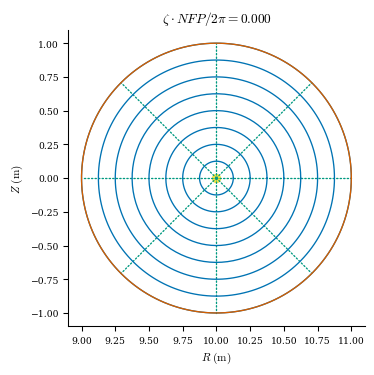

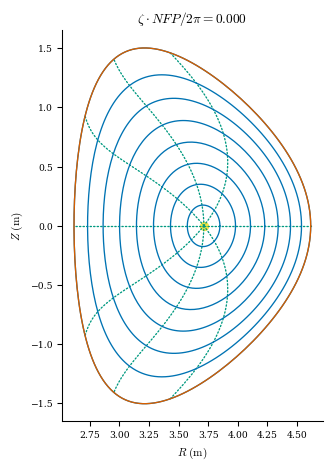

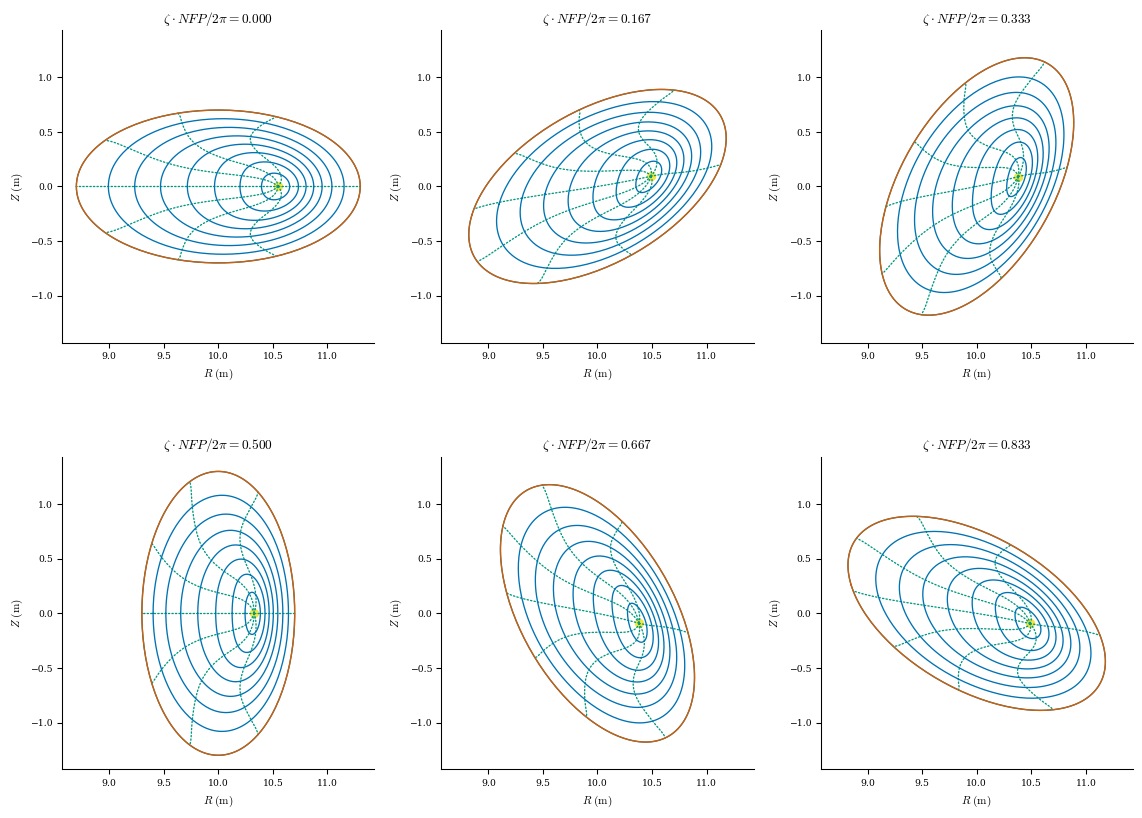

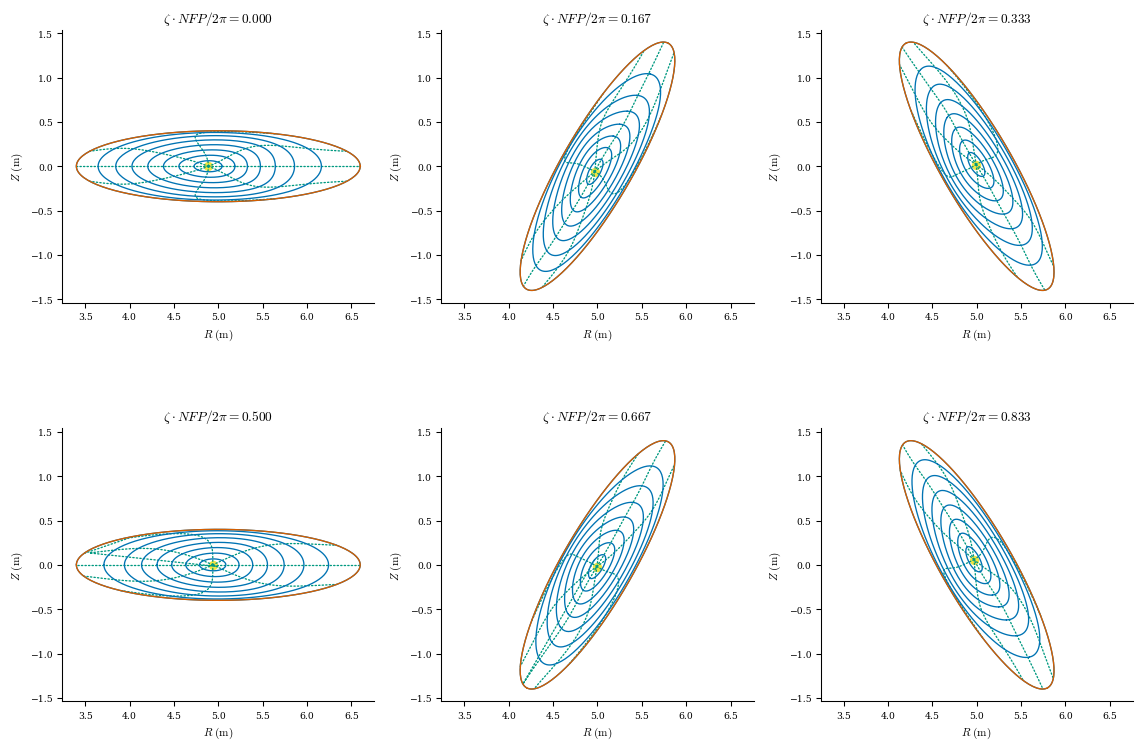

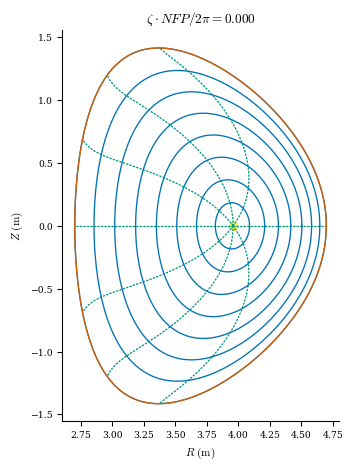

In [4]:
# to make sure equilibrium were solved correctly on my computer
for s in stellarators:
    plot_surfaces(s.eq)

In [5]:
for s in stellarators:
    s.print_values()

torus
Equilibrium at 0x7f95f8035550 (L=1, M=1, N=0, NFP=1, sym=False, spectral_indexing=ansi)
grid.spacing(dr,dt,dz) [1.         0.52359878 0.62831853]
Bsquare average 0.1013211836423378
DESC Magnetic Well v1 [5.20769917e-17]
DESC Magnetic Well v2 [7.20066147e-17]
d(magnetic pressure average)/dvolume v2 3.696093142819469e-20
d(magnetic pressure)/dvolume average v1 2.673107364942938e-20
d(thermal pressure)/drho 0.0
d(thermal pressure)/dvolume 0.0
d(total pressure average)/dvolume 3.696093142819469e-20
dvolume/drho 394.78417604357423
volume 197.39208802178715
data["V"] 198.93421370945734

DSHAPE
Equilibrium at 0x7f956c6217f0 (L=26, M=13, N=0, NFP=1.0, sym=1, spectral_indexing=fringe)
grid.spacing(dr,dt,dz) [1.         0.1013417  0.62831853]
Bsquare average 0.05754777715657761
DESC Magnetic Well v1 [0.10235007]
DESC Magnetic Well v2 [0.03705115]
d(magnetic pressure average)/dvolume v2 2.143852585872182e-05
d(magnetic pressure)/dvolume average v1 5.922176138904515e-05
d(thermal pressure)/d

In [6]:
for s in stellarators:
    s.compute_plot()

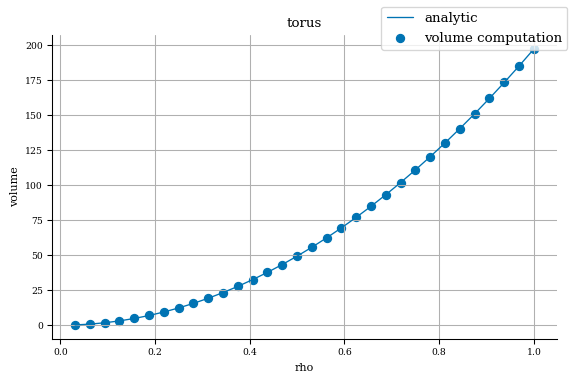

In [7]:
# compare volume computation to known analytic case for torus
fig, ax = plt.subplots()
s = "volume"
rho, volume = torus.st[s]
ax.scatter(rho, volume, label=s + " computation")
ax.plot(rho, 20 * (np.pi * rho) ** 2, label="analytic")
ax.set(xlabel="rho", ylabel=s, title=torus.name)
ax.grid()
fig.legend()

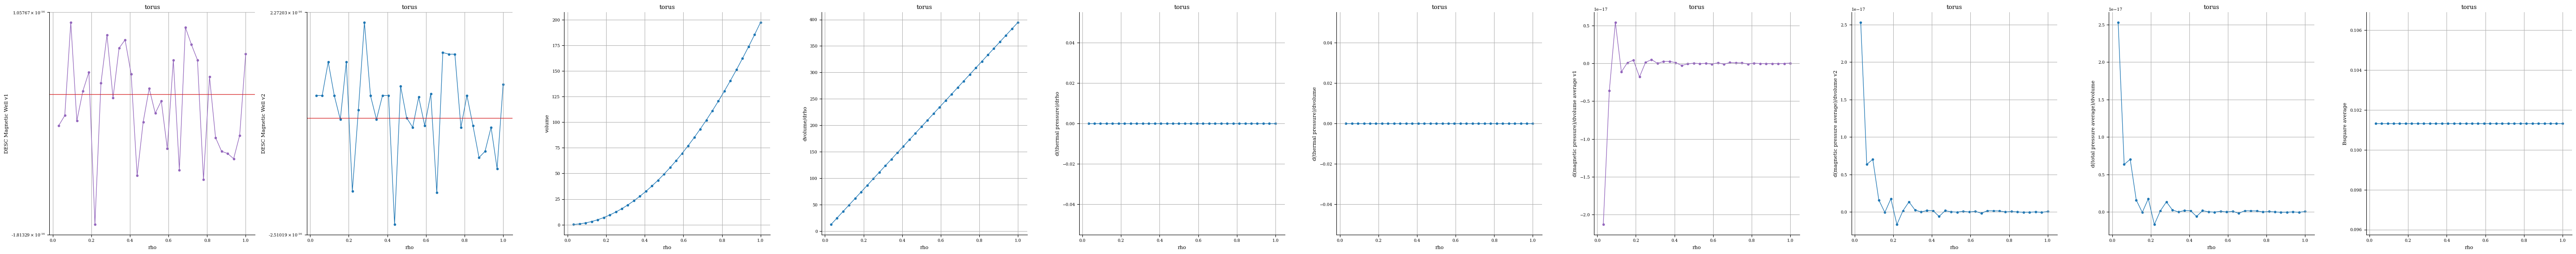

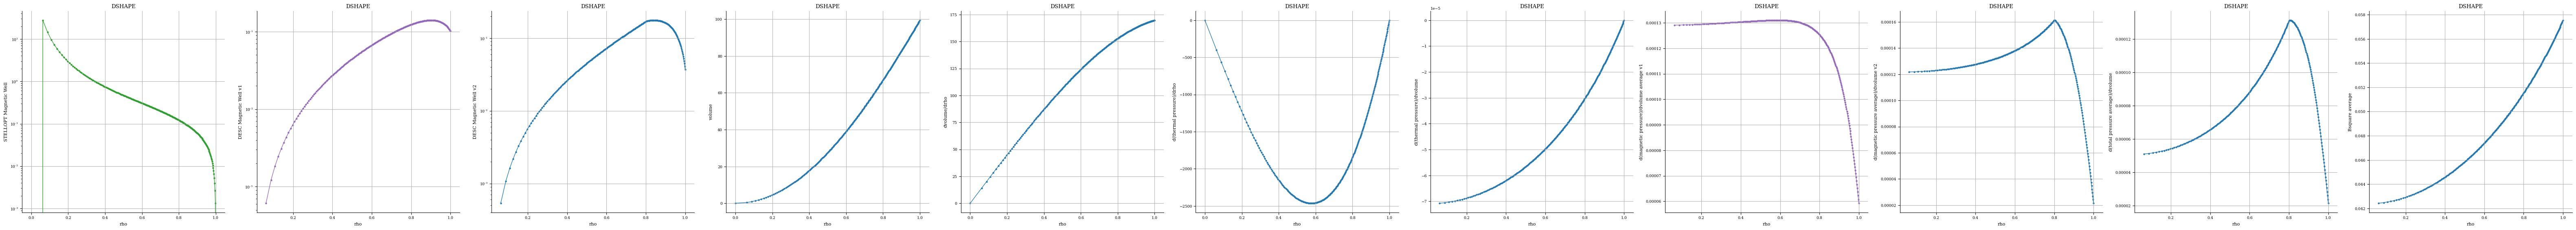

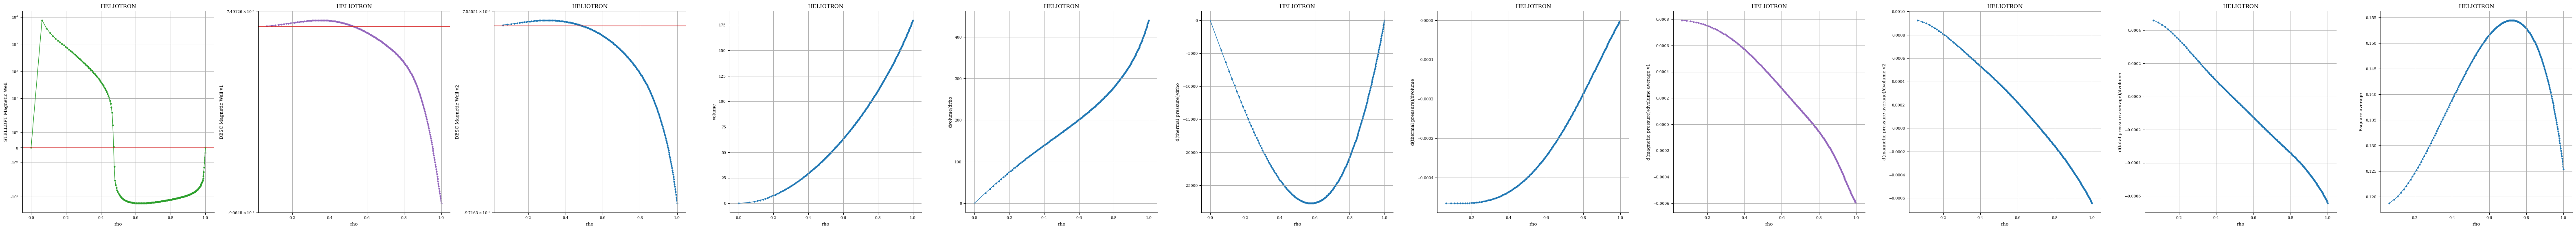

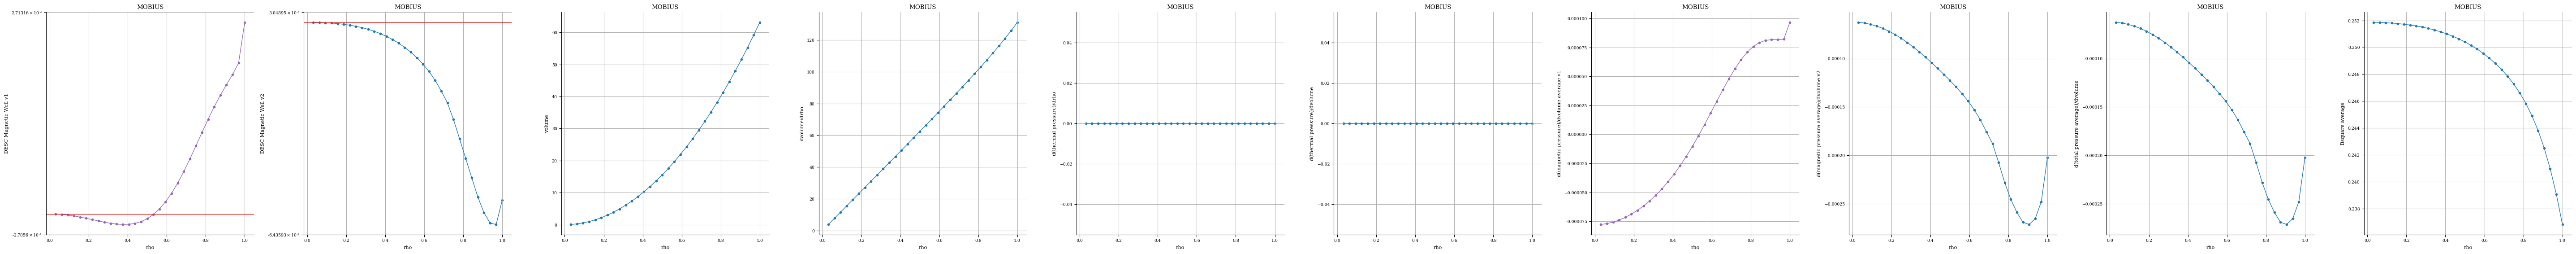

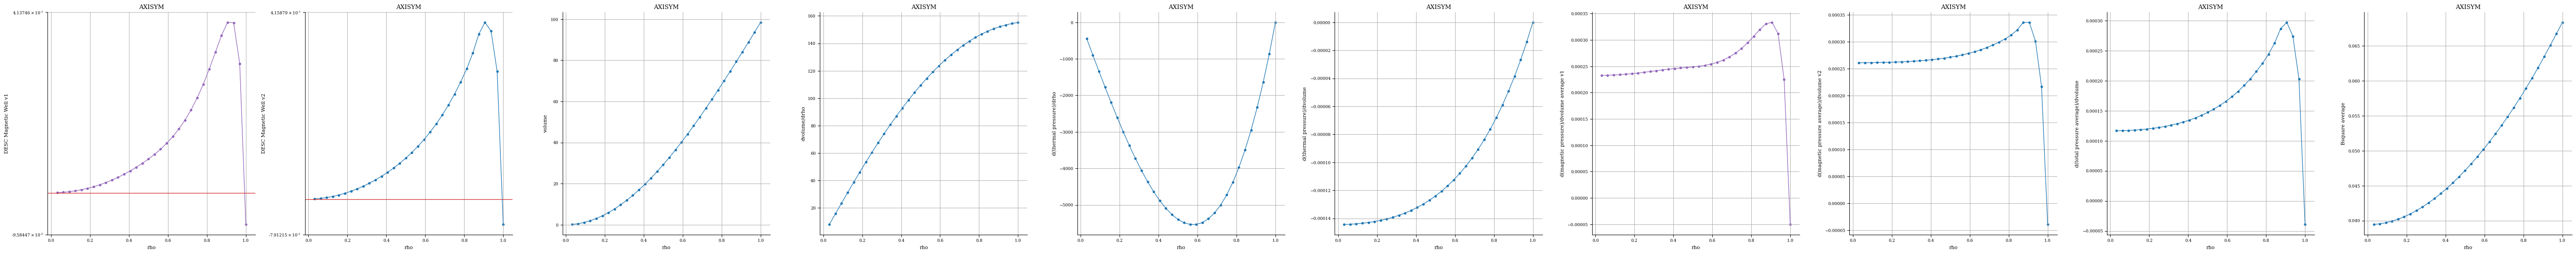

In [12]:
# the red line denotes the y=0 axis
# purple plots are of quantities known to be incorrect
# green plots are STELLOPT data
for s in stellarators:
    MagneticWellVisual.plot(s.name, s.st)

## volume computation problem and solution
In `MagneticWell.compute()`, the volume computation relies on the quantity `dtheta*dzeta`. This is obtained from splicing `grid.spacing`. The grid class takes advantage of things like reducing duplicated node weight, stellarator symmetry, and the number of field periods to reduce the amount of computation.

The problem is that, in the grid class's current implementation, the modifications made to `grid.spacing` to take advantage of symmetry and NFP do not preserve the value of `dtheta*dzeta`. So independently plucking out `dtheta*dzeta` from a grid will not give the value its name implies.

Why is this? Because rescaling is done to preserve the full volume, or the weights (`drho*dtheta*dzeta`) so that `grid.spacing.prod(axis=1).sum()` = 4 pi squared, at the expense of changing `dtheta*dzeta`. Here's a visual:

In [9]:
# For any constant rho (L=1) and NFP=1, grid.spacing is going
# to be an M*N length stack of the row vector (1, 2pi/M, 2pi/N).
g1 = LinearGrid(L=1, M=3, N=3)
print(g1.spacing)
print()
# When NFP != 1, the values of drho are increased (decreased) while
# dtheta*dzeta decreases (increases).
# That's why the wrong volume was being computed for the heliotron with NFP > 1.
g2 = LinearGrid(L=1, M=3, N=3, NFP=np.random.random_sample() * 100)
print(g2.spacing)

# the good thing is that the differential volume drho*dtheta*dzeta is preserved
# since that was the (main?) goal of the rescaling
assert np.allclose(g1.spacing.prod(axis=1), g2.spacing.prod(axis=1))
# and that, because rho=constant forces the drho vector to = 1 (with NFP=1),
# grid.weights is actually the value we expect from dtheta*dzeta (for any NFP).
assert np.allclose(g1.spacing.prod(axis=1), g1.spacing[:, 1:].prod(axis=1))
assert np.allclose(g1.spacing.prod(axis=1), g1.weights)  # definition of weights

[[1.        2.0943951 2.0943951]
 [1.        2.0943951 2.0943951]
 [1.        2.0943951 2.0943951]
 [1.        2.0943951 2.0943951]
 [1.        2.0943951 2.0943951]
 [1.        2.0943951 2.0943951]
 [1.        2.0943951 2.0943951]
 [1.        2.0943951 2.0943951]
 [1.        2.0943951 2.0943951]]

[[3.68092719 7.70931589 0.15457675]
 [3.68092719 7.70931589 0.15457675]
 [3.68092719 7.70931589 0.15457675]
 [3.68092719 7.70931589 0.15457675]
 [3.68092719 7.70931589 0.15457675]
 [3.68092719 7.70931589 0.15457675]
 [3.68092719 7.70931589 0.15457675]
 [3.68092719 7.70931589 0.15457675]
 [3.68092719 7.70931589 0.15457675]]


### solution

The correct volume will be computed for NFP >= 0, if we take `dtheta*dzeta` to be `grid.weights` instead of `grid.spacing[:, 1:].prod(axis=1)`.

The next, and last to my knowledge, source of error in the volume is the symmetry (quasi?) boolean. `enforce_symmetry()` again modifies `dtheta*dzeta`. Visual given below. The error in computed volume that results from this is much smaller than the NFP error fixed above.

The nodes with theta > pi are removed and so too are the spacings in the grid that correspond to those nodes. Now because `grid.spacing` is missing these nodes, to preserve the overall volume in rho, theta, zeta space (`grid.weights.sum()`), the differential volume `drho*dtheta*dzeta` of the remaining spaces is increased so that the sum is still 4 pi squared. This makes sense since we do want to increase the weight of the nodes 0 to pi to double count for the removed nodes. This process has preserving the volume `dr*dt*dz` in mind. It's not clear to me if a different scale factor (other than 4 pi squared) would be better to preserve an area element `dt*dz`. Might be dependent on rho.

In any case, the solution implemented here is to force stellarator symmetry to `False`. This is not ideal since it can simplify the computation of the transforms and such. An alternative could be to just recreate the grid with the nodes that were removed from `enforce_symmetry()` in the `MagneticWell` class and use this grid just for the volume computation. I don't think this would be too difficult. This could allow the grid with symmetry to still be used elsewhere.

In [10]:
g3 = LinearGrid(L=1, M=3, N=3, sym=True)
print(g3.spacing)

[[1.14471424 2.3974839  2.3974839 ]
 [1.14471424 2.3974839  2.3974839 ]
 [1.14471424 2.3974839  2.3974839 ]
 [1.14471424 2.3974839  2.3974839 ]
 [1.14471424 2.3974839  2.3974839 ]
 [1.14471424 2.3974839  2.3974839 ]]


### What to fix next?
I think the volume related quantities are what we want now. But the magnetic well parameter graph does not match STELLOPT. I'm going to see if the magnetic well parameter returns what we want when the volume flux surface label is replaced with rho. This was briefly mentioned in Greene's paper. If there are any other suggestions to look into please let me know.